# Representación Validación Cruzada

Se representan los resultados obtenidos de la validación cruzada. Se han escogido al menos 10 estaciones de calidad del aire para cada contaminante teniendo en cuenta los siguientes aspectos:

   > Que tuviesen suficientes datos para dicho contaminante
   >
   > Se situase en una ciudad con una alta población 
   >
   > Las estaciones de cada contaminante se situasen de manera homogénea por todo el territorio del país
   
La validación se ha realizado con los datos del 2013 al 2019, realizando un _Leave One Group Out_ utilizando para test un año natural completo y como train el resto. Ésto se ha realizado de manera iterativa para todos los años disponibles. En las tablas de datos se indica el año utilizado de test en cada iteración.

Las técnicas utilizadas en la validación han sido:

> Vecinos cercanos **(knn)**: Para distintos vecinos cercanos `k = 1:10`
> 
> randomForest **(rf)**: Para dististintos número de arboles `ntree = 10, 20, 30, 50, 100, 150, 200`
>
> Regresion Lineal **(lm)**

Para cada uno de los modelos obtenidos se les ha aplicado un ajuste fino mediante _qq Mapping_

Además, se ha probado añadiendo los datos meteorológicos de dias anteriores como outputs. En las tablas de resultados la columna `days` hace referencia a cuantos dias anteriores se han añadido, haciendo referencia el 0 a que solo se han tratado como outputs los datos meteorológicos del día. 

Los resultados se han guardado en un archivo `.rda` con el numbre de la técnica utilizada (*knn*, *rf* o *lm*) dentro de la carpeta ` Cross-validation/ `. Dentro de dicho archivo se encuentra una lista de `R` llamada `cross.val` con los siguientes valores:

> **metrics**: _data.frame_ con diferentes métricas para cada modelo.
>* RMSE: $\sqrt{\frac{\sum_i^N{({pred}_i - {obs}_i)^2}}{N}}$
>* bias: $\frac{\overline{pred}}{\overline{obs}}$
>* cor1: Correlación Pearson para los datos brutos de observación y predicción 
>* cor2: Correlación Pearson para los datos desestacionalizados de observación y predicción
>* var.ratio: $\frac{var(pred)}{var(obs)}$
>
> **predictions**: _data.frame_ con las series temporales observadas (`obs`), predichas por el modelo (`pred`) y con el ajuste fino _qq.Mapping_ (`pred.qq`)
>
> **predictions.ds**: _data.frame_ con las series temporales desestacionalizadas observadas (`obs`), predichas por el modelo (`pred`) y con el ajuste fino _qq.Mapping_ (`pred.qq`)

Cabe destacar que se ha obtenido la correlación entre la predicción y la observación desestacionalizados debido a que la propia tendencia sinusoidal de las series temporales aportan una gran correlacion a los modelos simplemente teniendo en cuenta esto. 

### Cargar paquetes

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

suppressMessages(library(openair))

In [2]:
# Cambiar la apariencia de las graficas en jupyter
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

### Notación en las gráficas

Se añade el formato correcto de cada una de las variables categóricas con el que deben aparecer en las gráficas. Si se quiere elimiar alguna de estas variables de las gráficas se puede hacer ahora y afectará al resto del notebook.

In [3]:
pollut.notation <- c("no" = expression(NO),
                     "no2" = expression(NO[3]),
                     "o3" = expression(O[3]),
                     "pm10" = expression(PM[10]),
                     "pm2.5" = expression(PM[2.5])
                    )
Error.notation <- c("bias" = "Bias Ratio",
                    "cor1" = "Correlation",
                    "cor2" = "Deseasonal Correlation",
                    "RMSE" = "Root Mean Square Error",
                    "var.ratio" = "Ratio of Variance"
                   )
site.notation <- c("es0118a" = "Madrid", "es1438a" = "Barcelona",
                   "es1625a" = "Valencia", "es0890a" = "Sevilla",
                   "es1047a" = "Zaragoza", "es1137a" = "Vigo",
                   "es1632a" = "Valladolid", "es0110a" = "Bilbao",
                   "es1580a" = "Santander", "es1340a" = "Huelva"
                   )


param.text <- list("rf" = "ntree", "knn" = "k-neighbors")
param.values <- list("rf" = c(10, 20, 30, 50, 100, 150, 200), 
                     "knn" = 1:10,
                     "lm" = 0
                    )

Se cargan los resultados de la técnica que se desee indicandola en la variable `method`

In [4]:
method <- "knn"  # knn, lm, rf

HOME <- "~/Repositories/AirQualityCOVID/"
load(paste(HOME, "data/Cross-validation/", method, ".rda", sep=""))

# Métricas

In [5]:
pivot.metrics <- cross.val$metrics %>%
        pivot_longer(cols = 7:ncol(cross.val$metrics),
                     names_to = "Error", values_to = "Err.Val")

In [6]:
dat.df <- pivot.metrics %>%
            filter(
                days %in% 0:3,
                site %in% names(site.notation),
                variable %in% names(pollut.notation),
                year %in% 2013:2019,
                param %in% param.values[[method]],
                qq.Mapping %in% c("Yes", "No"),
                Error %in% names(Error.notation)
            )

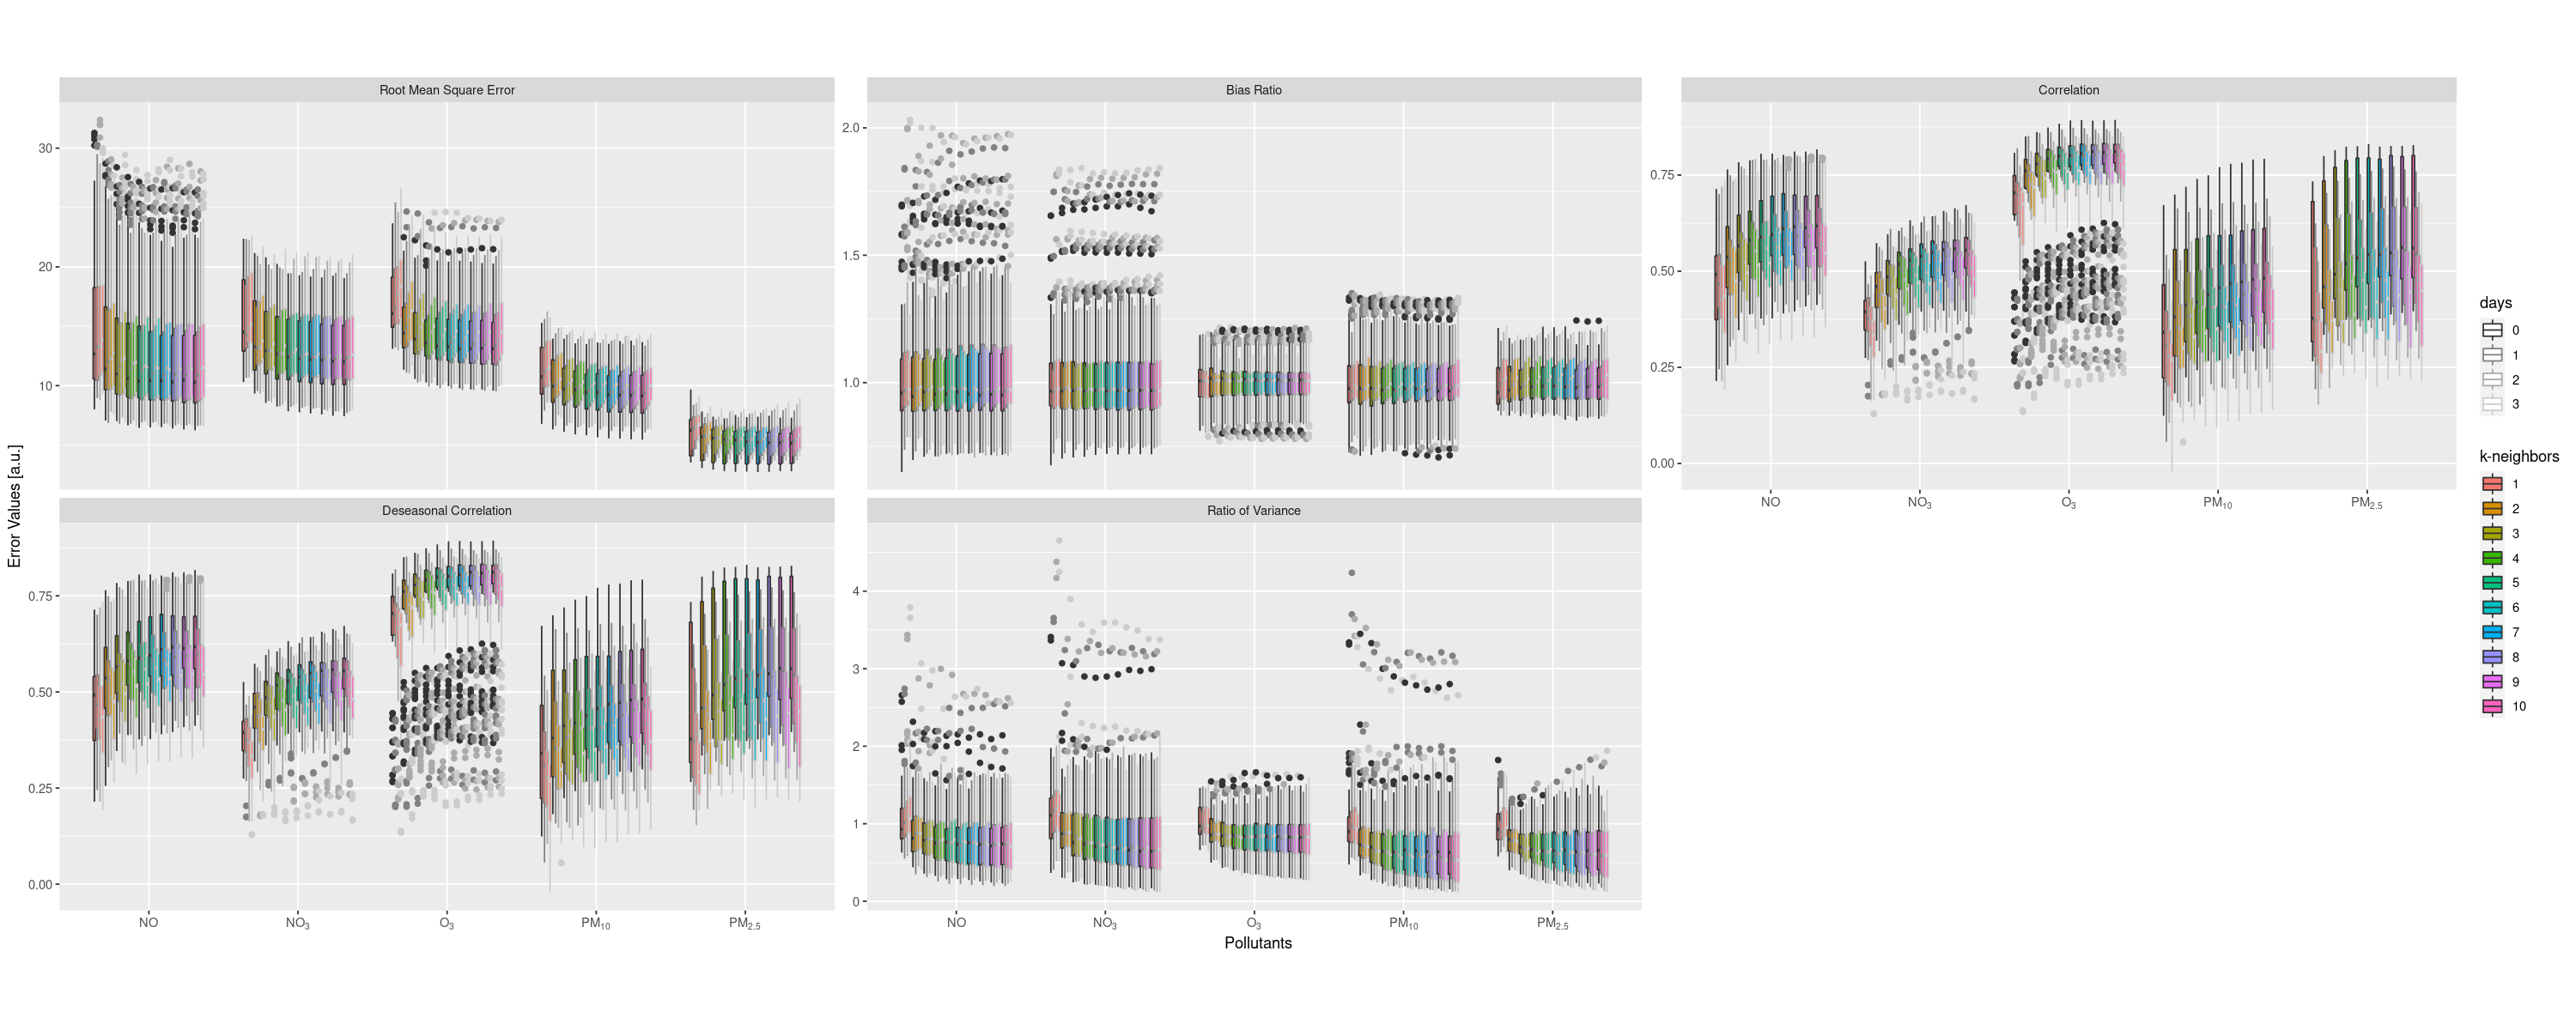

In [16]:
ggplot(data=dat.df) +
    geom_boxplot(aes(x=variable, y=Err.Val, fill=param, color=days)) +
    scale_color_grey() +
    facet_wrap(~Error, 
               scale="free_y", 
               labeller = labeller(Error=Error.notation)) +
    scale_x_discrete(name="Pollutants", labels=pollut.notation) +
    scale_y_continuous(name="Error Values [a.u.]") +
    scale_fill_discrete(name=param.text[method]) + theme(aspect.ratio = 0.5)

# Predicciones

In [9]:
predict.df <- cross.val$predictions %>%
            filter(
                days %in% 0:3,
                site %in% names(site.notation),
                variable %in% names(pollut.notation),
                year %in% 2013:2019,
                param %in% param.values[[method]]
            )

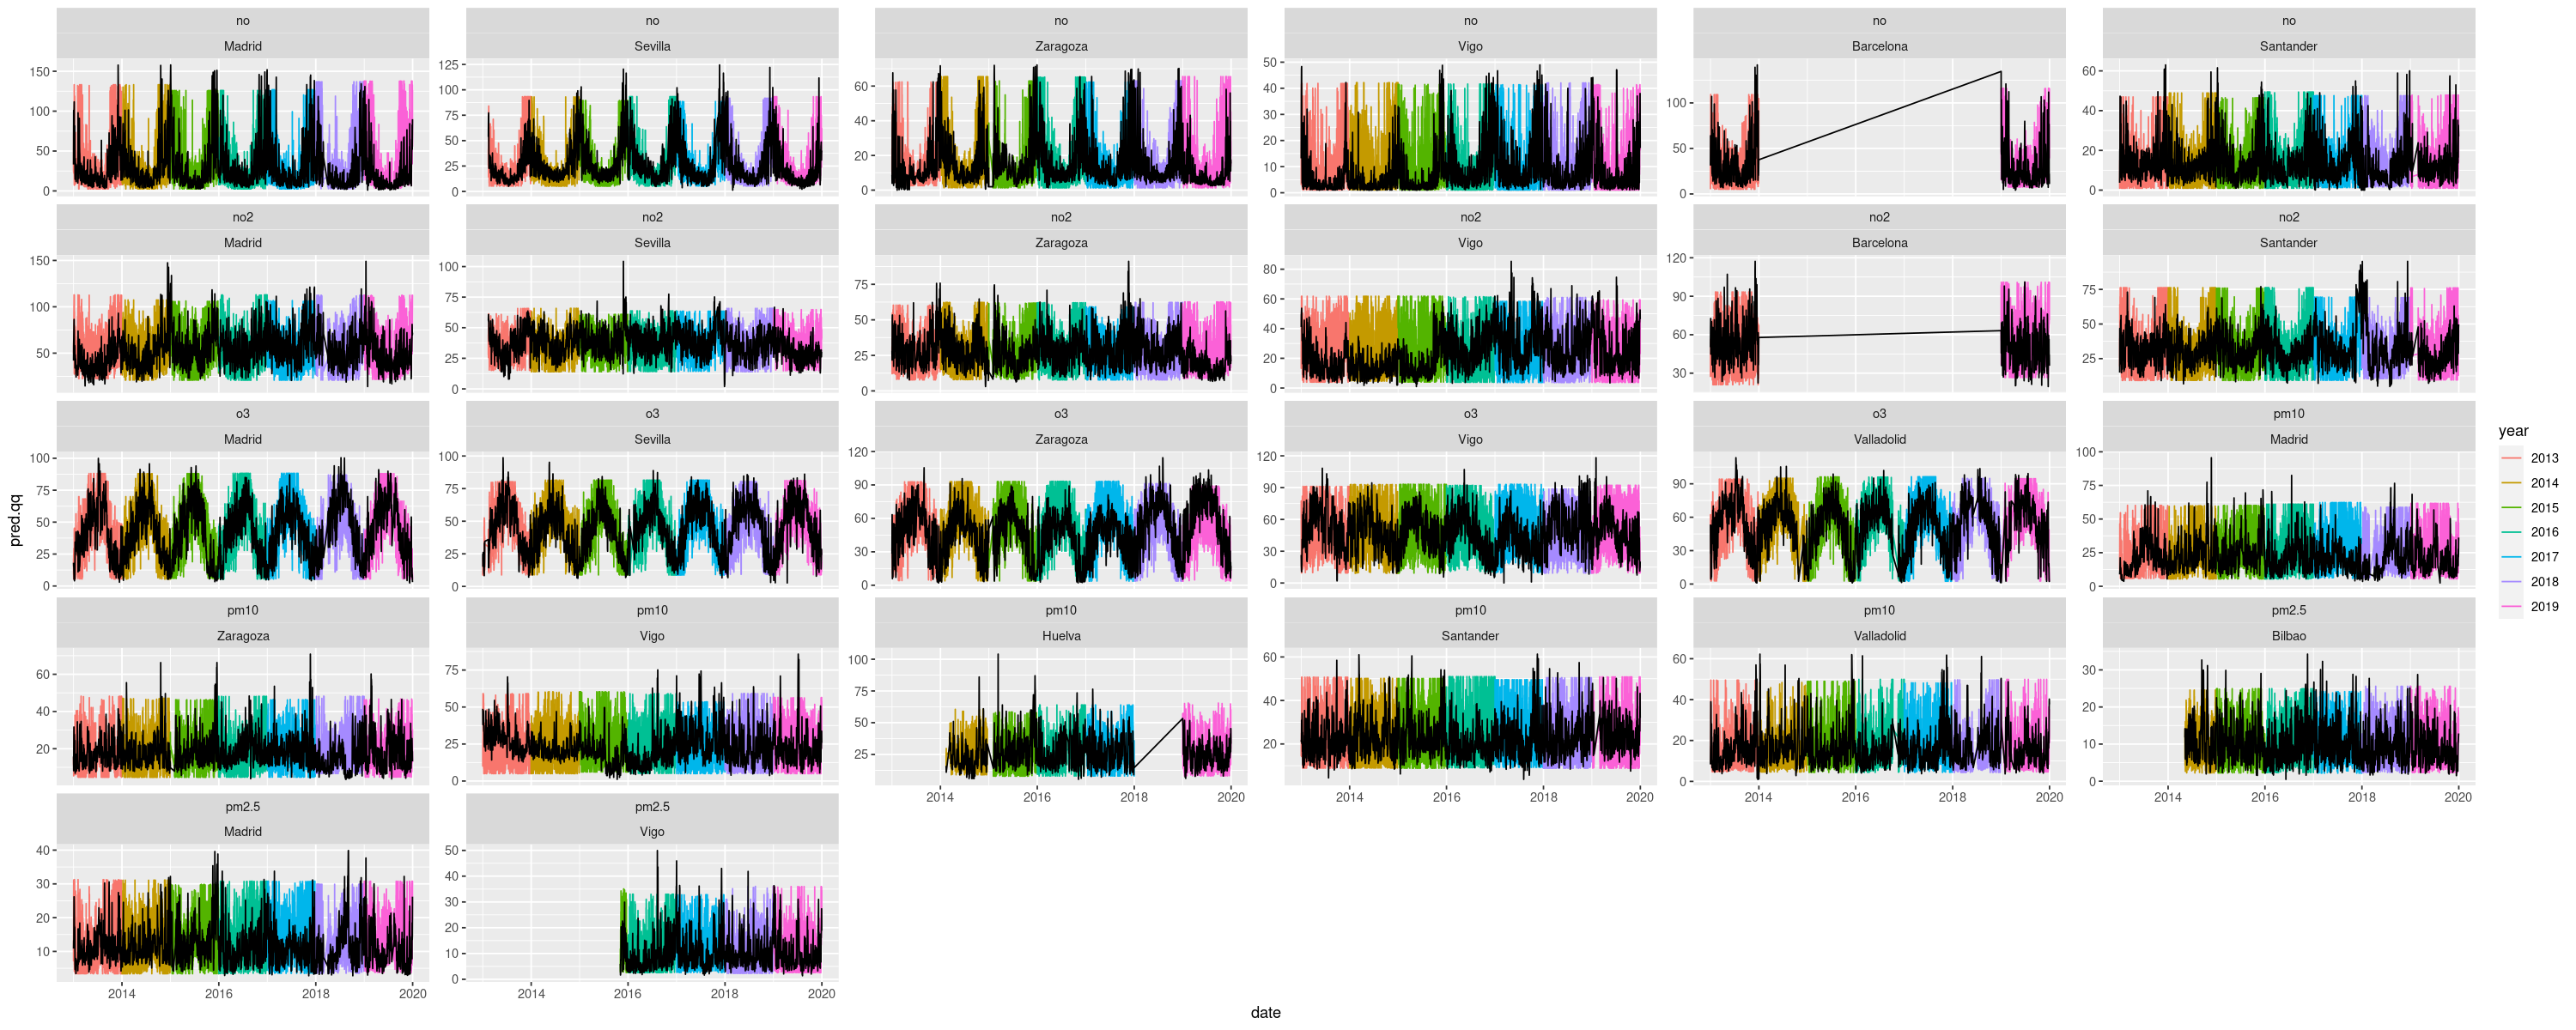

In [10]:
ggplot(data=predict.df) +
    geom_line(aes(x=date, y=pred.qq, color = year)) +
    geom_line(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site, 
               scale="free_y", 
               labeller = labeller(variable =  pollut.notation,
                                   site = site.notation))

In [11]:
test <- predict.df %>%
            rename(value = pred.qq) %>%
            timeAverage(avg.time = "2 week", 
                        type = c("days", "site", "variable", "param"))
test$variable <- factor(test$variable, labels=c(expression(NO),
                                                expression(NO[3]),
                                                expression(O[3]),
                                                expression(PM[10]),
                                                expression(PM[2.5])
                                               ))

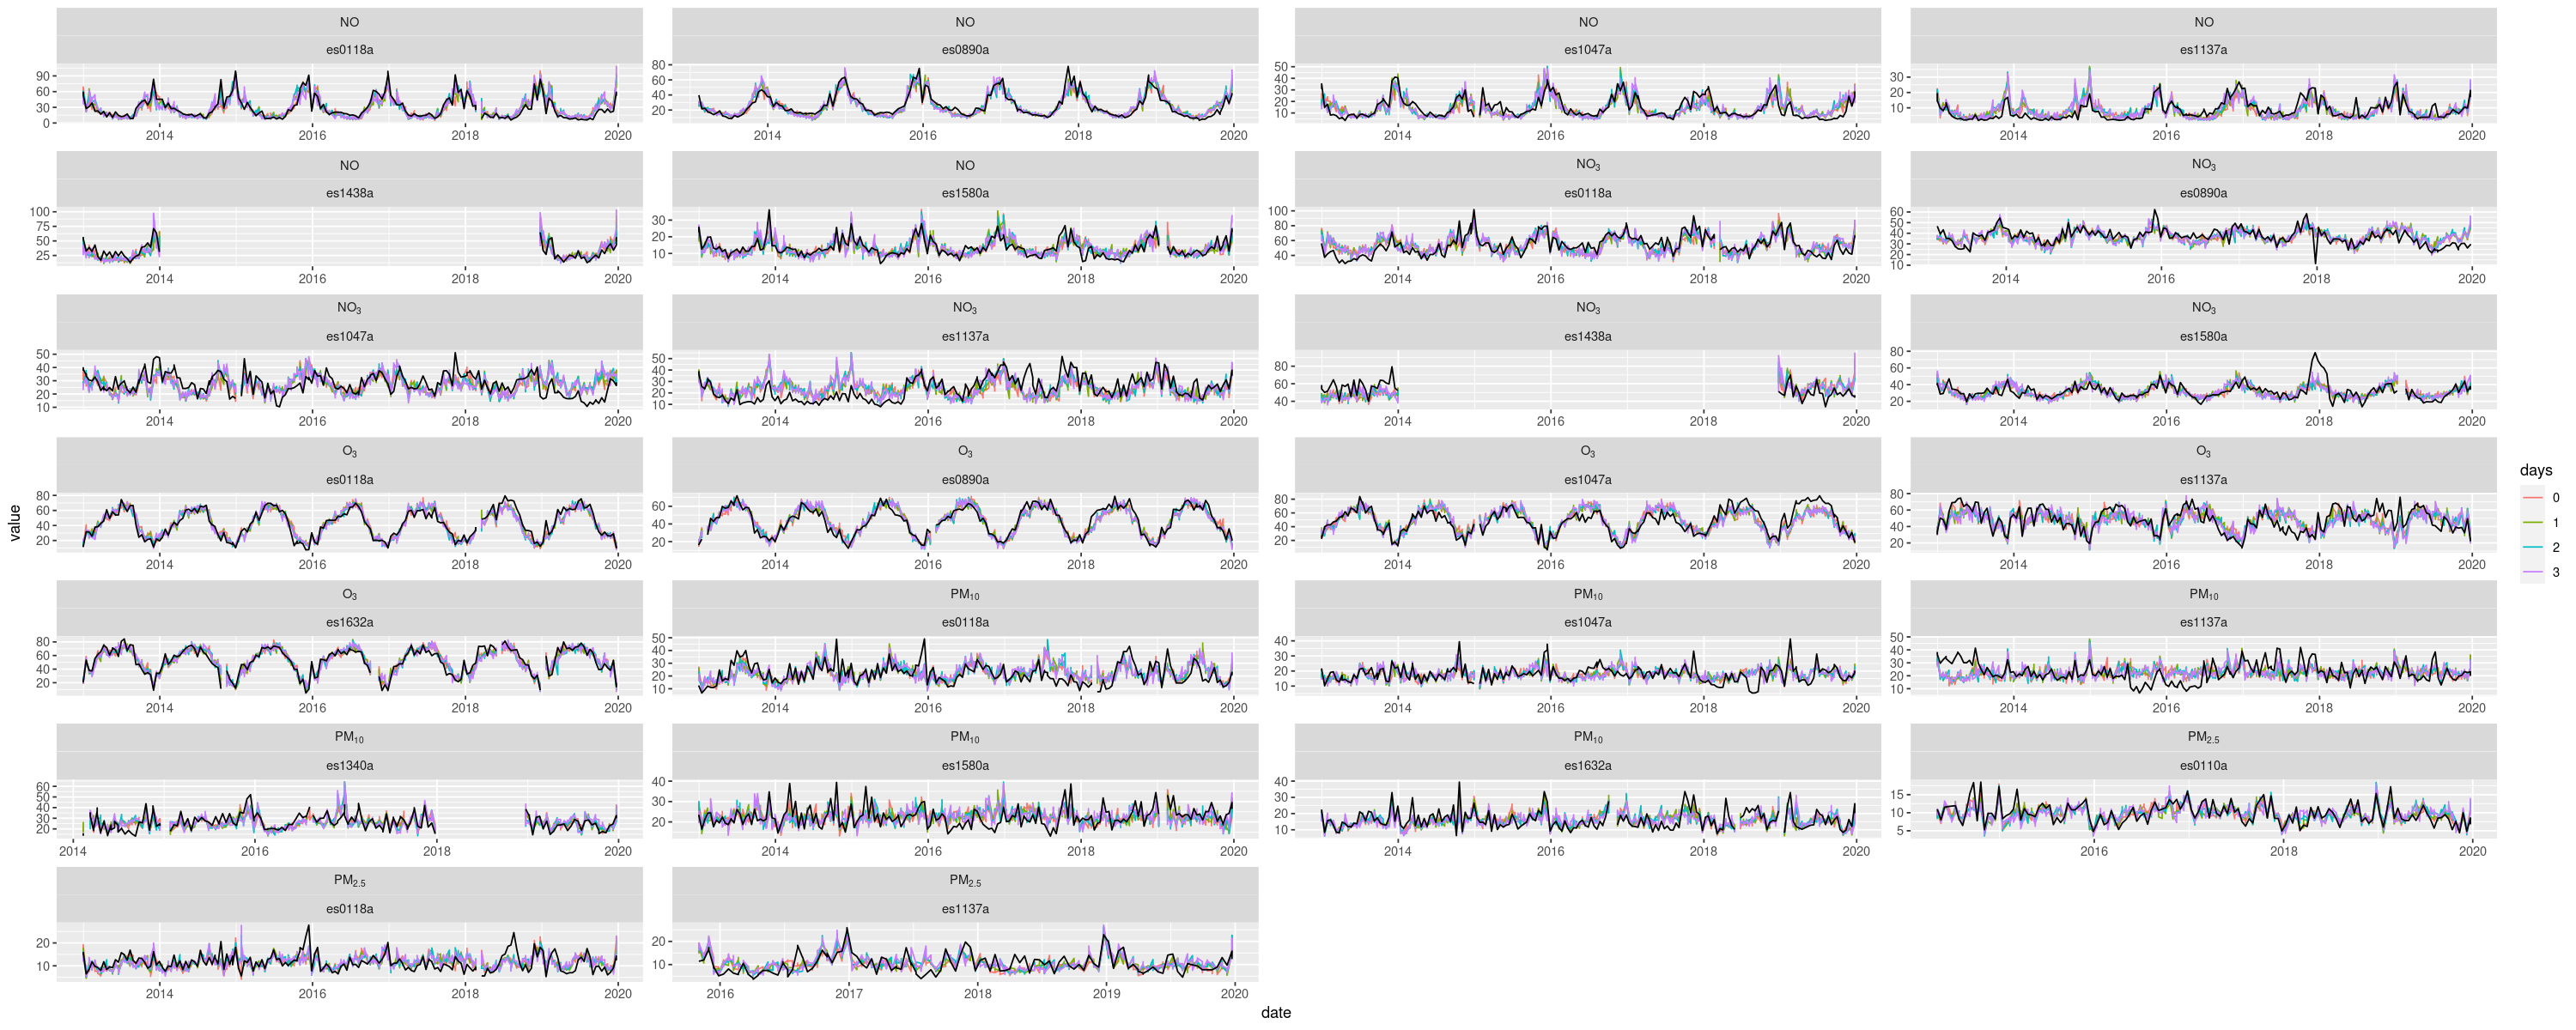

In [12]:
ggplot(data=test) +
    geom_line(aes(x=date, y=value, color = days)) +
    geom_line(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site, scale="free", ncol=4, labeller=label_parsed)

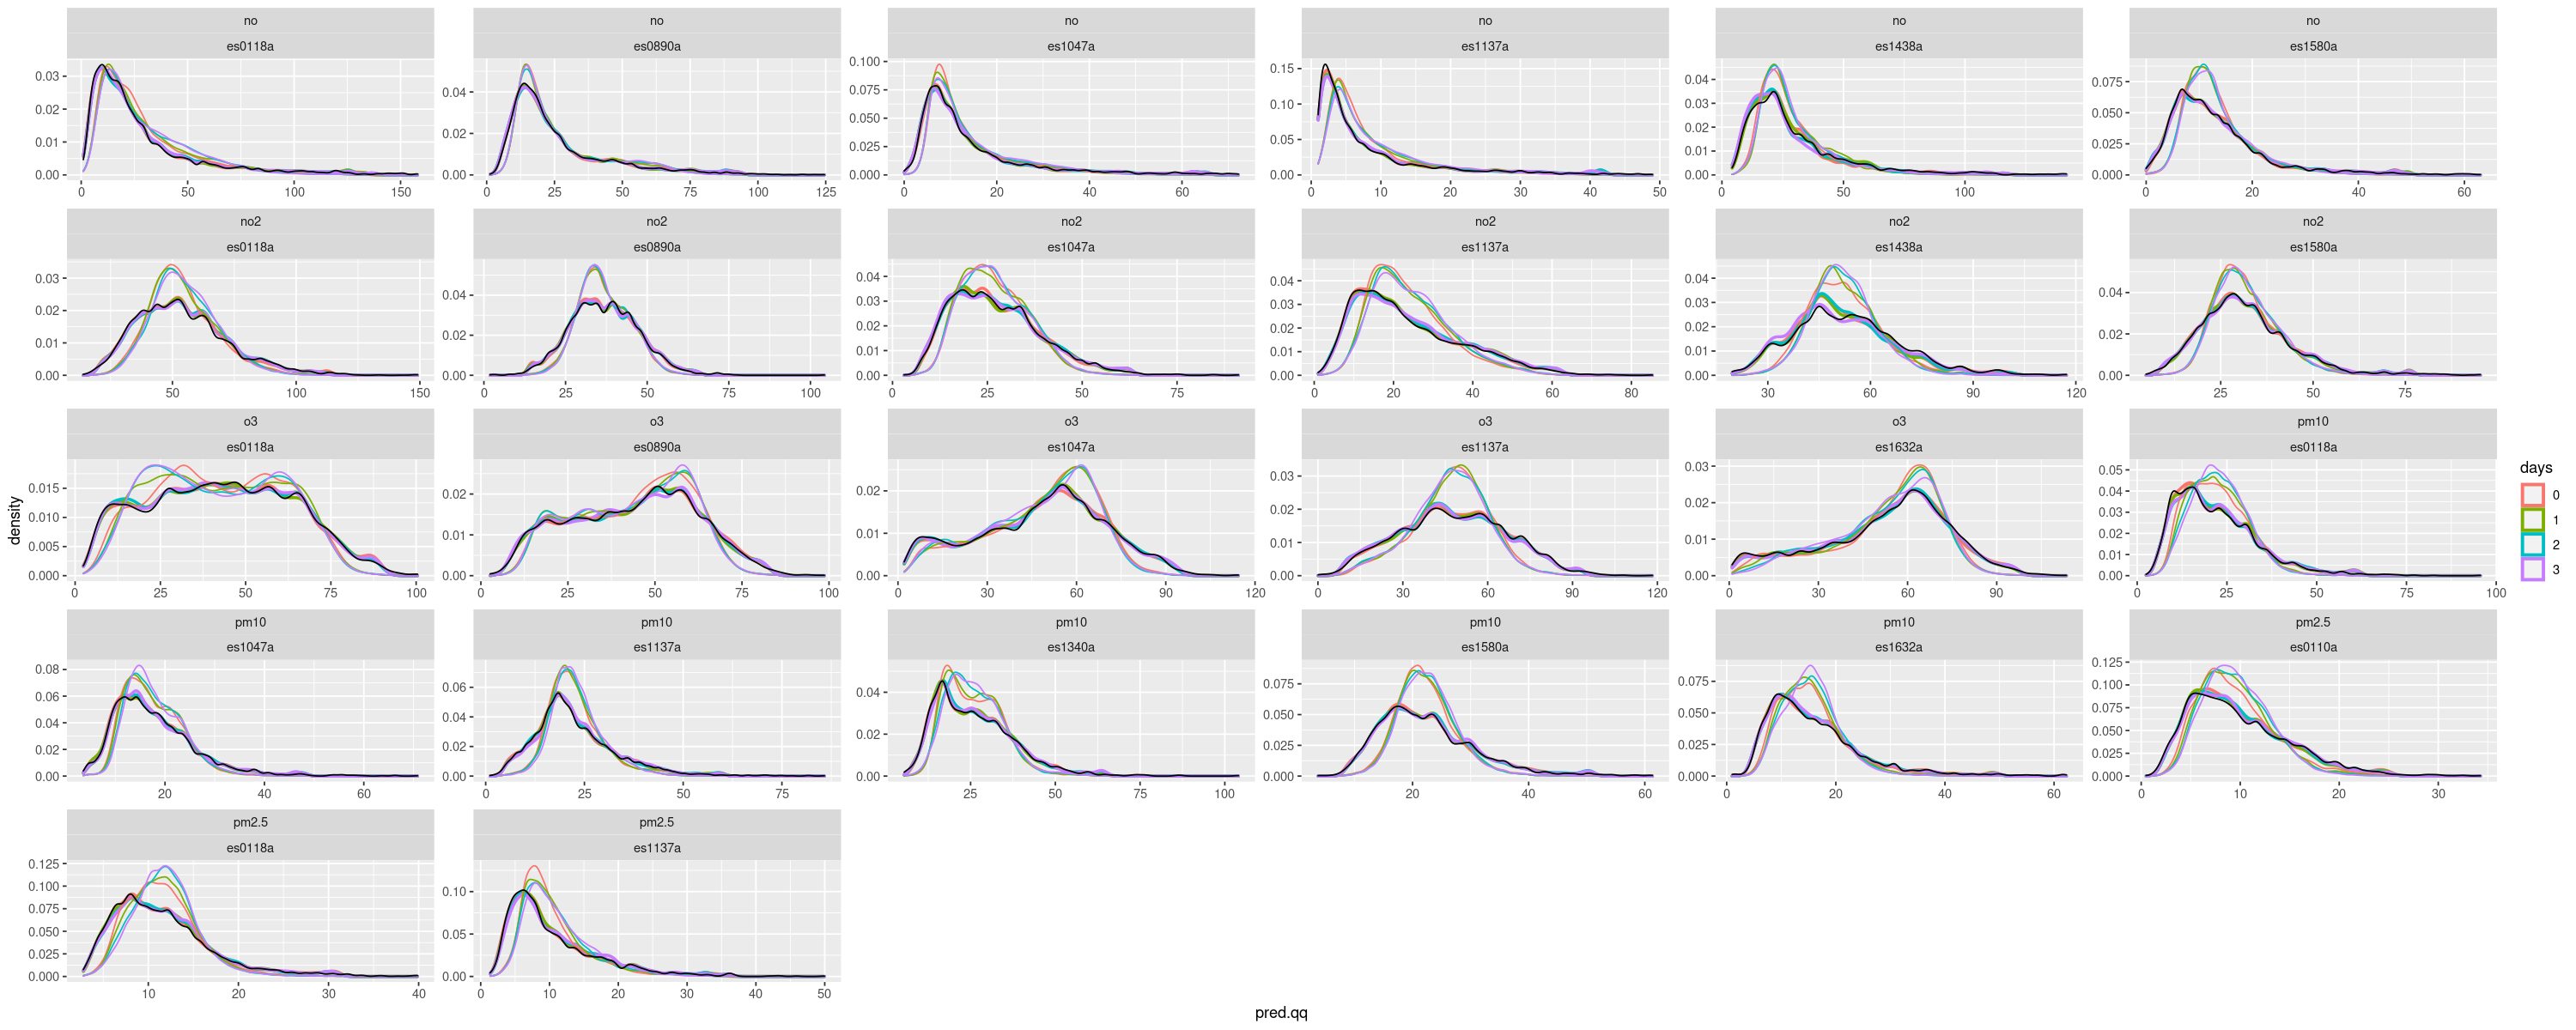

In [13]:
ggplot(data=predict.df) +
    geom_density(aes(x=pred.qq, color=days), size=1) +
    geom_density(aes(x=pred, color=days), size=0.5) +
    geom_density(aes(x=obs), color="black") +
    facet_wrap(~variable+site, scale="free")